<a href="https://colab.research.google.com/github/swilsonmfc/imbalanced/blob/main/ForestCover.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forest Cover

# Install

In [1]:
!pip install imblearn

# Setup

In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from sklearn.preprocessing import StandardScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

import imblearn
from imblearn.metrics import classification_report_imbalanced 
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.under_sampling import TomekLinks

import ipywidgets as widgets
from ipywidgets import interact

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data

## Load

In [4]:
!wget -O covtype.data.gz https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz

--2020-10-19 10:09:39--  https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11240707 (11M) [application/x-httpd-php]
Saving to: ‘covtype.data.gz’

covtype.data.gz     100%[===================>]  10.72M  8.16MB/s    in 1.3s    

2020-10-19 10:09:41 (8.16 MB/s) - ‘covtype.data.gz’ saved [11240707/11240707]



In [5]:
!gunzip covtype.data.gz

## Columns

In [6]:
numeric = ['elevation',
'aspect',
'slope',
'horizontal_distance_to_hydrology',
'vertical_distance_to_hydrology',
'horizontal_distance_to_roadways',
'hillshade_9am',
'hillshade_noon',
'hillshade_3pm',
'horizontal_distance_to_fire_points',
]
wilderness = [f'wilderness_area_{x}' for x in range(4)] 
soil       = [f'soil_type_{x}' for x in range(40)]  
target     = ['cover_type']

columns = numeric + wilderness + soil + target

## Read

In [7]:
df = pd.read_csv('covtype.data', names=columns)

In [8]:
df.head()

,elevation,aspect,slope,horizontal_distance_to_hydrology,vertical_distance_to_hydrology,horizontal_distance_to_roadways,hillshade_9am,hillshade_noon,hillshade_3pm,horizontal_distance_to_fire_points,wilderness_area_0,wilderness_area_1,wilderness_area_2,wilderness_area_3,soil_type_0,soil_type_1,soil_type_2,soil_type_3,soil_type_4,soil_type_5,soil_type_6,soil_type_7,soil_type_8,soil_type_9,soil_type_10,soil_type_11,soil_type_12,soil_type_13,soil_type_14,soil_type_15,soil_type_16,soil_type_17,soil_type_18,soil_type_19,soil_type_20,soil_type_21,soil_type_22,soil_type_23,soil_type_24,soil_type_25,soil_type_26,soil_type_27,soil_type_28,soil_type_29,soil_type_30,soil_type_31,soil_type_32,soil_type_33,soil_type_34,soil_type_35,soil_type_36,soil_type_37,soil_type_38,soil_type_39,cover_type
0,2596,51,3,258,0,510,221,232,148,6279,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,5


In [9]:
print(f'Examples {len(df):,}')

Examples 581,012


# EDA

In [10]:
def plot_feature(df, feature, outcome='cover_type'):
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,6))
  df.hist(feature, ax=ax1)
  ax1.set_xlabel(feature)
  ax1.set_title(f'Histogram for {feature}')
  df.boxplot(feature, by=outcome, ax=ax2)
  ax2.set_ylabel(feature)
  ax2.set_title(f'{feature} grouped by Cover Type')
  plt.show();

def plot_class_density(df, feature, outcome='cover_type'):
  fig = plt.figure(figsize=(12, 6))
  sns.kdeplot(df[feature], hue=df[outcome], palette='gist_rainbow')
  plt.show();

## Target
* Imbalanced

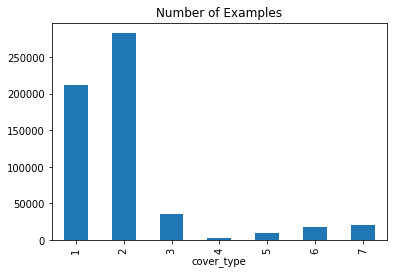

In [11]:
df.groupby('cover_type').size().plot.bar()
plt.title('Number of Examples');

In [12]:
# Ratio of examples relative to smallest class
grp = df.groupby('cover_type').size()
(grp / min(grp))

cover_type
1     77.116855
2    103.131052
3     13.015653
4      1.000000
5      3.455770
6      6.322170
7      7.466327
dtype: float64

## Missing
* No missing values to contend with

In [13]:
df.isna().sum()

elevation                             0
aspect                                0
slope                                 0
horizontal_distance_to_hydrology      0
vertical_distance_to_hydrology        0
horizontal_distance_to_roadways       0
hillshade_9am                         0
hillshade_noon                        0
hillshade_3pm                         0
horizontal_distance_to_fire_points    0
wilderness_area_0                     0
wilderness_area_1                     0
wilderness_area_2                     0
wilderness_area_3                     0
soil_type_0                           0
soil_type_1                           0
soil_type_2                           0
soil_type_3                           0
soil_type_4                           0
soil_type_5                           0
soil_type_6                           0
soil_type_7                           0
soil_type_8                           0
soil_type_9                           0
soil_type_10                          0


## Elevation
* Elevation has variation across classes that we can use

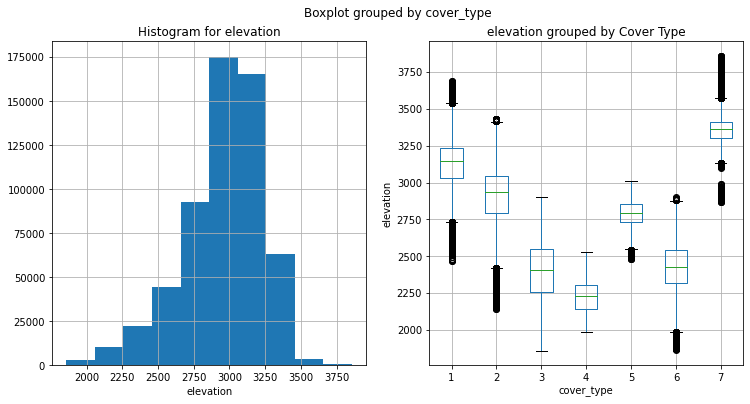

In [14]:
plot_feature(df, 'elevation')

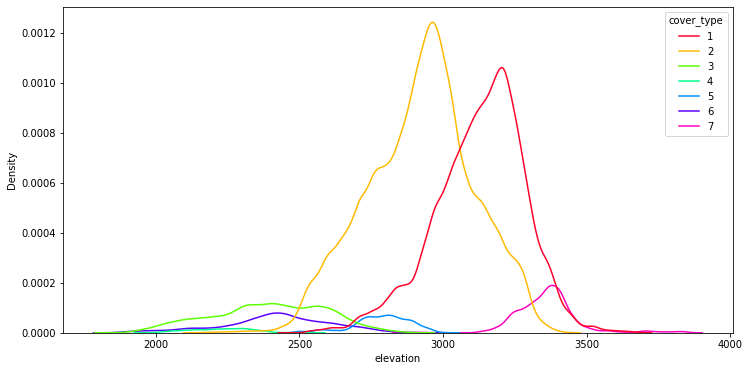

In [15]:
plot_class_density(df, 'elevation')

## Aspect
* Cover Type (4) has a number of large outliers

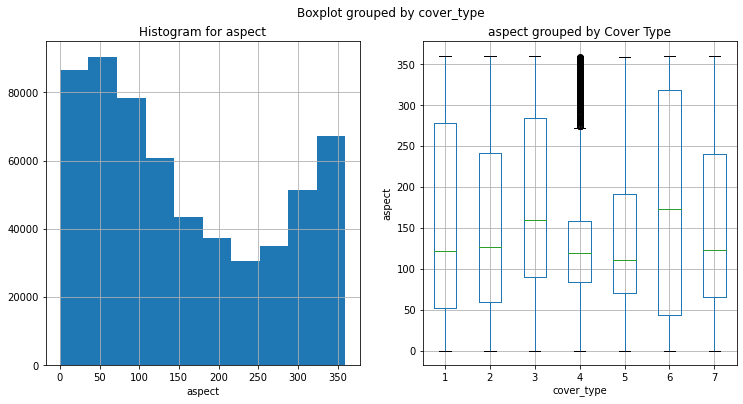

In [16]:
plot_feature(df, 'aspect')

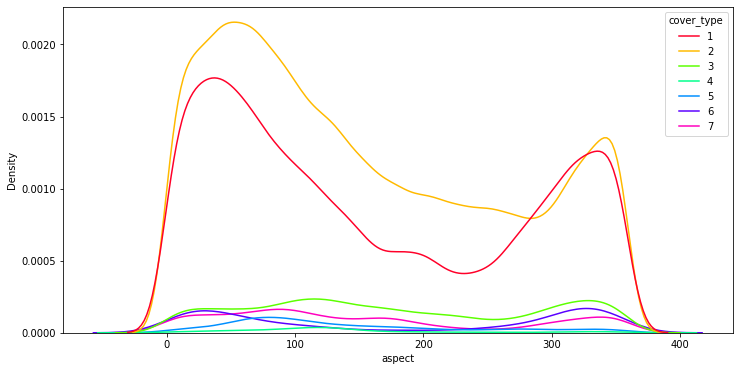

In [17]:
plot_class_density(df, 'aspect')

## Numeric Viewer
* Interactive viewer for less variable features

In [18]:
@interact
def run(column=numeric):
  plot_feature(df, column)
  plot_class_density(df, column)

interactive(children=(Dropdown(description='column', options=('elevation', 'aspect', 'slope', 'horizontal_dist…

## Correlations

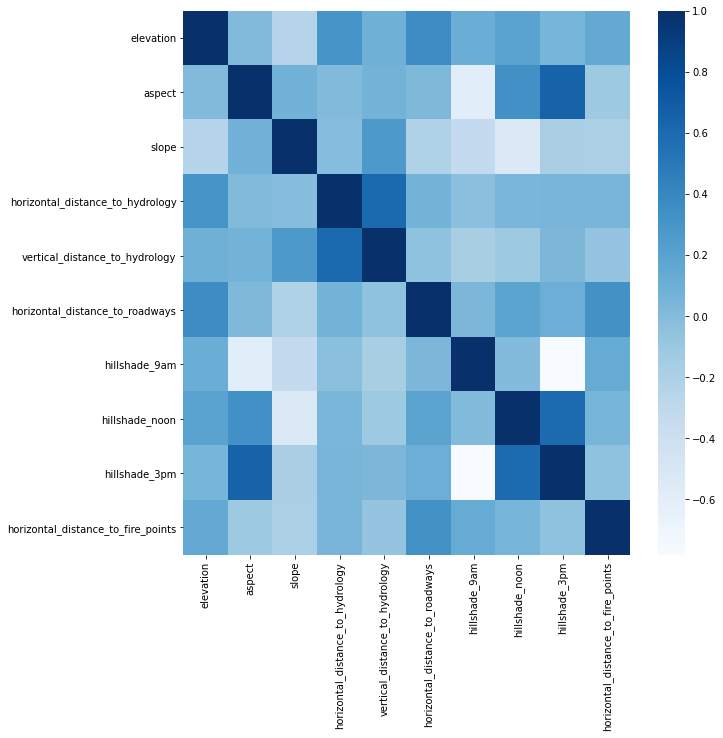

In [19]:
plt.figure(figsize=(10, 10))
sns.heatmap(df[numeric].corr(), cmap='Blues');

## Soil Type
* There is variability across soil types and cover types

In [20]:
# This is one hot encoded in the data
assert np.max(np.sum(df[soil], axis=1)) == 1

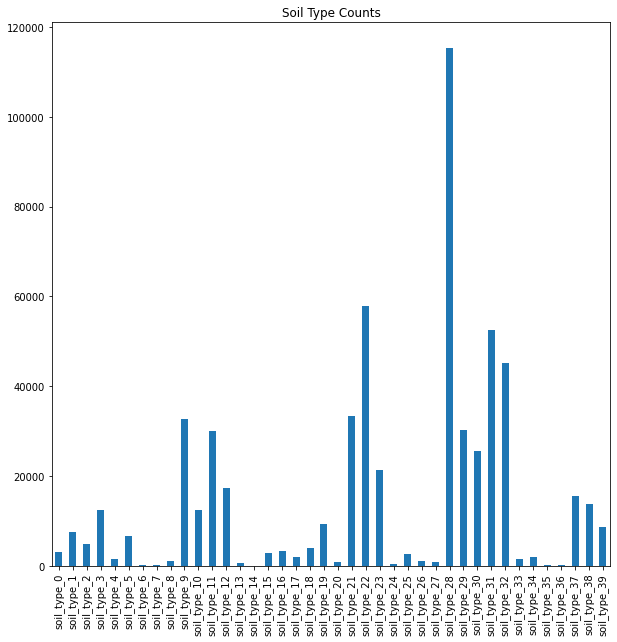

In [21]:
plt.figure(figsize=(10, 10))
df[soil].sum().plot.bar()
plt.title('Soil Type Counts');

In [22]:
dataset = df[soil + ['cover_type']].copy()
dataset['soil_type'] = dataset[soil].idxmax(axis=1)
dataset['value'] = 1
dataset = dataset[['soil_type', 'cover_type', 'value']]
piv = dataset.pivot_table(index='soil_type', columns='cover_type', values='value', 
                    aggfunc='count', fill_value=0, margins=True)
piv = piv.div(piv.All, axis=0).mul(100.)
piv = piv.drop(index='All', columns='All')
piv

cover_type,1,2,3,4,5,6,7
soil_type,,,,,,,
soil_type_0,0.000000,0.000000,69.317057,5.872649,0.000000,24.810294,0.000000
soil_type_1,0.000000,11.322259,66.325581,1.528239,3.508306,17.315615,0.000000
soil_type_10,6.019339,73.142627,10.902498,0.273973,5.487510,4.174053,0.000000
soil_type_11,8.985353,91.014647,0.000000,0.000000,0.000000,0.000000,0.000000
soil_type_12,12.603981,76.059893,0.235213,0.000000,7.544031,3.522460,0.034421
soil_type_13,0.000000,0.000000,19.365609,25.876461,0.000000,54.757930,0.000000
soil_type_14,0.000000,0.000000,0.000000,0.000000,0.000000,100.000000,0.000000
soil_type_15,22.355009,61.265378,4.534271,1.792619,1.230228,8.822496,0.000000
soil_type_16,6.253653,27.966102,14.786674,12.741087,17.533606,20.718878,0.000000


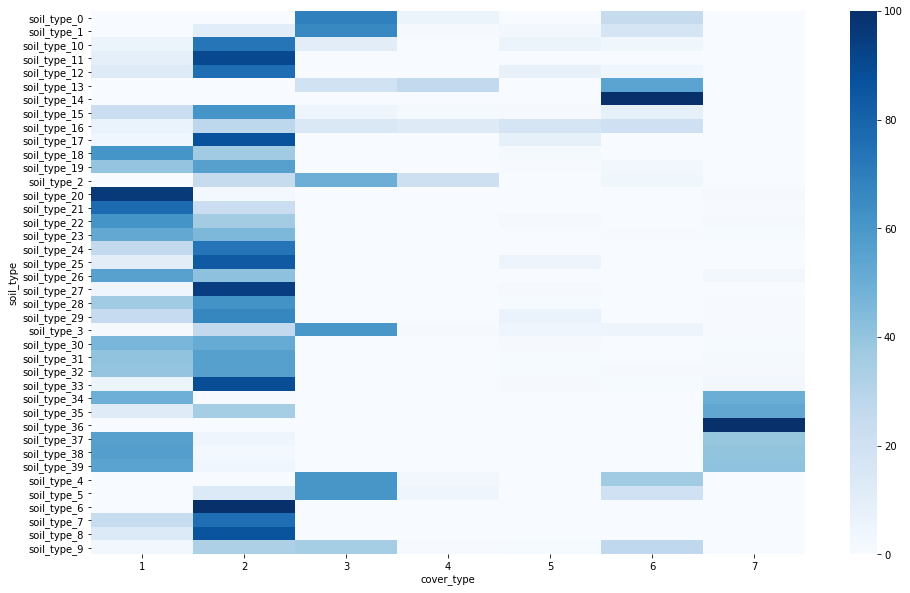

In [23]:
plt.figure(figsize=(16, 10))
sns.heatmap(piv, cmap='Blues')

## Wilderness

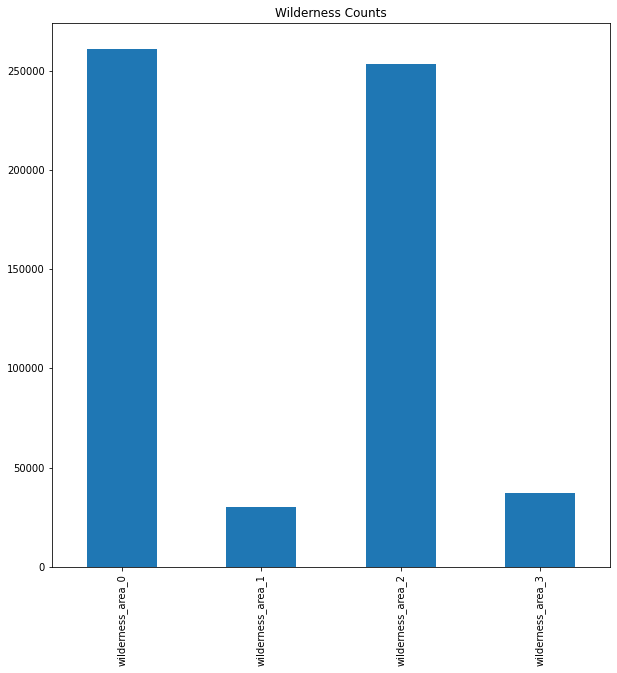

In [24]:
plt.figure(figsize=(10, 10))
df[wilderness].sum().plot.bar()
plt.title('Wilderness Counts');

In [25]:
# Compute Percentages By Type
dataset = df[wilderness + ['cover_type']].copy()
dataset['wilderness_type'] = dataset[wilderness].idxmax(axis=1)
dataset['value'] = 1
dataset = dataset[['wilderness_type', 'cover_type', 'value']]
piv = dataset.pivot_table(index='wilderness_type', columns='cover_type', values='value', 
                    aggfunc='count', fill_value=0, margins=True)
piv = piv.div(piv.All, axis=0).mul(100.)
piv = piv.drop(index='All', columns='All')
piv

cover_type,1,2,3,4,5,6,7
wilderness_type,,,,,,,
wilderness_area_0,40.536281,56.057992,0.000000,0.000000,1.449792,0.000000,1.955935
wilderness_area_1,62.223933,30.066256,0.000000,0.000000,0.000000,0.000000,7.709811
wilderness_area_2,34.546344,49.372839,5.644054,0.000000,2.254464,3.009899,5.172400
wilderness_area_3,0.000000,8.185458,58.033975,7.430751,0.000000,26.349816,0.000000


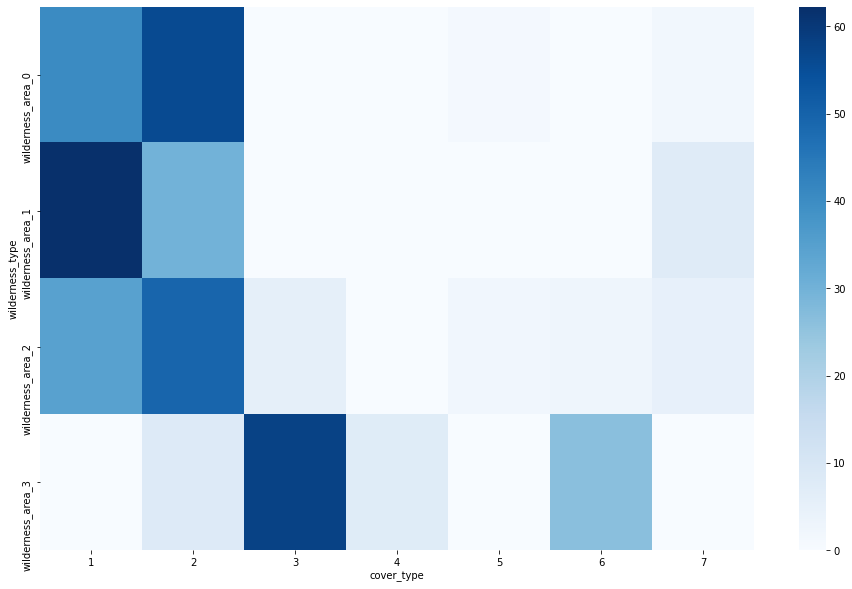

In [26]:
plt.figure(figsize=(16, 10))
sns.heatmap(piv, cmap="Blues")

# Metrics
* Measure Accuracy and F1 Score (using macro averaging)
* Use balancing technique on Training dataset
* Use model to forecast on hold out test dataset

# Tracking

In [27]:
results_df = pd.DataFrame(columns=['Accuracy', 'F1'])

## Feature Treatments
* Train - Test split (stratified)
* Standard Scale numeric columns

## Train Test
* Stratified train-test split

In [28]:
X = df.copy()
X = X.drop(columns=['cover_type'])
y = df['cover_type']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

# Scaling

In [29]:
X_train = X_train.copy()
X_test  = X_test.copy()

scalers = {}
for feature in numeric:
  scaler = StandardScaler()
  X_train[feature] = scaler.fit_transform(X_train[[feature]])
  X_test[feature]  = scaler.transform(X_test[[feature]])
  scalers[feature] = scaler

# Naive
* Guess the majority class

In [36]:
mode  = y_train.mode()
y_hat = np.repeat([mode], len(y_test))

accuracy = accuracy_score(y_test, y_hat)
f1       = f1_score(y_test, y_hat, average='macro')

print(classification_report_imbalanced(y_test, y_hat))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.00      0.00      1.00      0.00      0.00      0.00     52960
          2       0.49      1.00      0.00      0.66      0.00      0.00     70825
          3       0.00      0.00      1.00      0.00      0.00      0.00      8938
          4       0.00      0.00      1.00      0.00      0.00      0.00       687
          5       0.00      0.00      1.00      0.00      0.00      0.00      2373
          6       0.00      0.00      1.00      0.00      0.00      0.00      4342
          7       0.00      0.00      1.00      0.00      0.00      0.00      5128

avg / total       0.24      0.49      0.51      0.32      0.00      0.00    145253



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [35]:
results_df.loc['Baseline'] = [accuracy, f1]
results_df

,Accuracy,F1
Baseline,0.487598,0.09365


# RandomForest
* Try various combinations of RandomForest with Imbalanced Treatments

## Unbalanced

In [37]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_hat = model.predict(X_test)
acc = accuracy_score(y_test, y_hat)
f1  = f1_score(y_test, y_hat, average='macro')
print(classification_report_imbalanced(y_test, y_hat))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.96      0.94      0.98      0.95      0.96      0.92     52960
          2       0.95      0.97      0.95      0.96      0.96      0.93     70825
          3       0.94      0.96      1.00      0.95      0.98      0.96      8938
          4       0.93      0.85      1.00      0.89      0.92      0.84       687
          5       0.93      0.77      1.00      0.84      0.88      0.75      2373
          6       0.94      0.89      1.00      0.91      0.94      0.88      4342
          7       0.97      0.95      1.00      0.96      0.97      0.94      5128

avg / total       0.95      0.95      0.97      0.95      0.96      0.92    145253



In [38]:
results_df.loc['RandomForest'] = [acc, f1]
results_df

,Accuracy,F1
Baseline,0.487598,0.093650
RandomForest,0.953688,0.924717


## Balanced

In [39]:
model = RandomForestClassifier(class_weight='balanced')
model.fit(X_train, y_train)
y_hat = model.predict(X_test)
acc = accuracy_score(y_test, y_hat)
f1  = f1_score(y_test, y_hat, average='macro')
print(classification_report_imbalanced(y_test, y_hat))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.96      0.94      0.98      0.95      0.96      0.92     52960
          2       0.95      0.97      0.95      0.96      0.96      0.93     70825
          3       0.94      0.96      1.00      0.95      0.98      0.96      8938
          4       0.92      0.86      1.00      0.89      0.93      0.84       687
          5       0.94      0.79      1.00      0.86      0.89      0.78      2373
          6       0.93      0.89      1.00      0.91      0.94      0.87      4342
          7       0.97      0.95      1.00      0.96      0.97      0.94      5128

avg / total       0.95      0.95      0.97      0.95      0.96      0.92    145253



In [40]:
results_df.loc['BalancedRandomForest'] = [acc, f1]
results_df

,Accuracy,F1
Baseline,0.487598,0.093650
RandomForest,0.953688,0.924717
BalancedRandomForest,0.954073,0.925815


## Weighted

In [41]:
grp = df.groupby('cover_type').size()
weights = {key: val for key, val in (grp // min(grp)).iteritems()}
weights

{1: 77, 2: 103, 3: 13, 4: 1, 5: 3, 6: 6, 7: 7}

In [42]:
model = RandomForestClassifier(class_weight=weights)
model.fit(X_train, y_train)
y_hat = model.predict(X_test)
acc = accuracy_score(y_test, y_hat)
f1  = f1_score(y_test, y_hat, average='macro')
print(classification_report_imbalanced(y_test, y_hat))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.96      0.94      0.98      0.95      0.96      0.92     52960
          2       0.95      0.97      0.95      0.96      0.96      0.92     70825
          3       0.94      0.96      1.00      0.95      0.98      0.95      8938
          4       0.93      0.85      1.00      0.89      0.92      0.84       687
          5       0.94      0.74      1.00      0.83      0.86      0.72      2373
          6       0.93      0.89      1.00      0.91      0.94      0.88      4342
          7       0.97      0.94      1.00      0.96      0.97      0.94      5128

avg / total       0.95      0.95      0.97      0.95      0.96      0.92    145253



In [43]:
results_df.loc['WeightedRandomForest'] = [acc, f1]
results_df

,Accuracy,F1
Baseline,0.487598,0.093650
RandomForest,0.953688,0.924717
BalancedRandomForest,0.954073,0.925815
WeightedRandomForest,0.952159,0.920491


## TomekLinks

In [44]:
sampler = TomekLinks()
X_smote, y_smote = sampler.fit_resample(X_train, y_train)

model = RandomForestClassifier()
model.fit(X_smote, y_smote)
y_hat = model.predict(X_test)
acc = accuracy_score(y_test, y_hat)
f1  = f1_score(y_test, y_hat, average='macro')
print(classification_report_imbalanced(y_test, y_hat))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.96      0.94      0.98      0.95      0.96      0.91     52960
          2       0.95      0.97      0.95      0.96      0.96      0.92     70825
          3       0.94      0.96      1.00      0.95      0.98      0.95      8938
          4       0.92      0.87      1.00      0.89      0.93      0.86       687
          5       0.93      0.76      1.00      0.84      0.87      0.74      2373
          6       0.93      0.88      1.00      0.91      0.94      0.87      4342
          7       0.97      0.94      1.00      0.96      0.97      0.94      5128

avg / total       0.95      0.95      0.97      0.95      0.96      0.92    145253



In [45]:
results_df.loc['TomekLinks+RandomForest'] = [acc, f1]
results_df

,Accuracy,F1
Baseline,0.487598,0.093650
RandomForest,0.953688,0.924717
BalancedRandomForest,0.954073,0.925815
WeightedRandomForest,0.952159,0.920491
TomekLinks+RandomForest,0.950328,0.921271


## SMOTE


In [46]:
sampler = SMOTE()
X_smote, y_smote = sampler.fit_resample(X_train, y_train)

model = RandomForestClassifier()
model.fit(X_smote, y_smote)
y_hat = model.predict(X_test)
acc = accuracy_score(y_test, y_hat)
f1  = f1_score(y_test, y_hat, average='macro')
print(classification_report_imbalanced(y_test, y_hat))

                   pre       rec       spe        f1       geo       iba       sup

          1       0.96      0.95      0.98      0.96      0.96      0.93     52960
          2       0.96      0.96      0.96      0.96      0.96      0.93     70825
          3       0.94      0.97      1.00      0.95      0.98      0.96      8938
          4       0.90      0.90      1.00      0.90      0.95      0.89       687
          5       0.85      0.91      1.00      0.88      0.95      0.90      2373
          6       0.90      0.93      1.00      0.91      0.96      0.92      4342
          7       0.95      0.97      1.00      0.96      0.99      0.97      5128

avg / total       0.96      0.96      0.97      0.96      0.97      0.93    145253



In [47]:
results_df.loc['SMOTE+RandomForest'] = [acc, f1]
results_df

,Accuracy,F1
Baseline,0.487598,0.093650
RandomForest,0.953688,0.924717
BalancedRandomForest,0.954073,0.925815
WeightedRandomForest,0.952159,0.920491
TomekLinks+RandomForest,0.950328,0.921271
SMOTE+RandomForest,0.956104,0.932112


# Results
* Measure Error Rate as 100.0 - F1 Score
* Report Percent Better than Next Best
* Scoring Highest F1, SMOTE (an oversampling technique) performed best

In [50]:
results_df['Error Rate'] = 1. - results_df.F1
results_df = results_df.sort_values('Error Rate', ascending=True)
top = results_df.iloc[0]['Error Rate']
results_df['Percent Better'] = (results_df['Error Rate'] - top) * 100. / top
results_df

,Accuracy,F1,Error Rate,Percent Better
SMOTE+RandomForest,0.956104,0.932112,0.067888,0.000000
BalancedRandomForest,0.954073,0.925815,0.074185,9.275640
RandomForest,0.953688,0.924717,0.075283,10.893125
TomekLinks+RandomForest,0.950328,0.921271,0.078729,15.970338
WeightedRandomForest,0.952159,0.920491,0.079509,17.119332
Baseline,0.487598,0.093650,0.906350,1235.074719


# Variable Importance
* The top performing model, SMOTE and Random Forests indicated these variables as important:

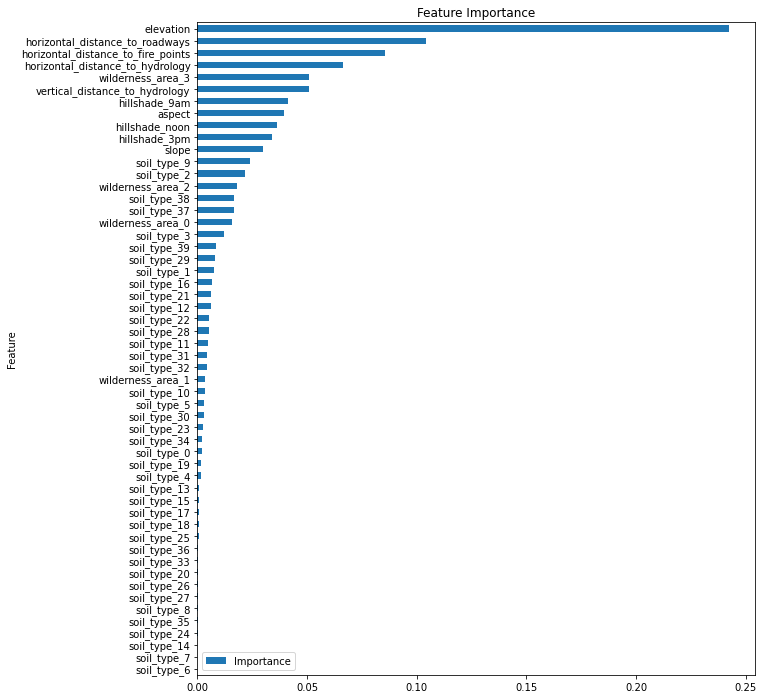

In [69]:
imp_df = pd.DataFrame([i for i in zip(X_train.columns, model.feature_importances_)])
imp_df.columns = ['Feature', 'Importance']
imp_df = imp_df.set_index('Feature')

imp_df = imp_df.sort_values('Importance').plot.barh(figsize=(10, 12))
plt.title('Feature Importance');

# Complete Example
* This notebook focuses on a workflow to compare SMOTE & TomekLinks with RandomForests on the Forest Cover dataset.
* A more complete example would likely include:
  * Hypertuning number of trees & selection / splits (we used default 100)
  * Compare other algorithms (Logistic, Boosting, MLP)
  * Interactions & Other Feature Treatments